# EDA - UAT 403 (București)

### Data Sources
Three aggregated datasets containing daily measurements:
1. **Cloud Cover** (`Aggregated_CloudCover/UAT_403.csv`)
2. **Humidity and Wind** (`Aggregated_Humidity_and_Wind/UAT_403.csv`)
3. **Temperature and UTCI** (`Aggregated_Temp_and_UTCI/UAT_403.csv`)

### Objectives
1. Load and merge all datasets, validate date alignment
2. Document all variables with narrative descriptions
3. Compute descriptive statistics (mean, std, min, max, quartiles)
4. Visualize time series evolution for each variable
5. Analyze correlations between variables
6. Identify anomalies/peaks in the data

---
## 1. Setup and Data Loading

In [2]:
%pip install -r requirements.txt

Note: you may need to restart the kernel to use updated packages.


In [ ]:
# Install nbstripout to remove output from Jupyter notebooks before committing to version control
import subprocess
import os
subprocess.run(["nbstripout", "--install"], cwd=os.getcwd())

CompletedProcess(args=['nbstripout', '--install'], returncode=1)

In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = (14, 6)
plt.rcParams['font.size'] = 11
sns.set_palette('husl')

DATA_DIR = Path('../data/unziped_data')
UAT_ID = '403'

In [37]:
df_cloud = pd.read_csv(DATA_DIR / 'Aggregated_CloudCover' / f'UAT_{UAT_ID}.csv')
df_humidity = pd.read_csv(DATA_DIR / 'Aggregated_Humidity_and_Wind' / f'UAT_{UAT_ID}.csv')
df_temp = pd.read_csv(DATA_DIR / 'Aggregated_Temp_and_UTCI' / f'UAT_{UAT_ID}.csv')

print(f'Cloud Cover dataset: {df_cloud.shape[0]} rows, {df_cloud.shape[1]} columns')
print(f'Humidity and Wind dataset: {df_humidity.shape[0]} rows, {df_humidity.shape[1]} columns')
print(f'Temperature and UTCI dataset: {df_temp.shape[0]} rows, {df_temp.shape[1]} columns')

Cloud Cover dataset: 10958 rows, 4 columns
Humidity and Wind dataset: 10958 rows, 8 columns
Temperature and UTCI dataset: 10958 rows, 8 columns


---
## 2. Data Alignment Validation

We need to verify that all three datasets are aligned by date.

In [11]:
df_cloud['date'] = pd.to_datetime(df_cloud['date'])
df_humidity['date'] = pd.to_datetime(df_humidity['date'])
df_temp['date'] = pd.to_datetime(df_temp['date'])

print(f'Cloud Cover:      {df_cloud["date"].min()} to {df_cloud["date"].max()}')
print(f'Humidity & Wind:  {df_humidity["date"].min()} to {df_humidity["date"].max()}')
print(f'Temperature:      {df_temp["date"].min()} to {df_temp["date"].max()}')

Cloud Cover:      1995-01-01 00:00:00 to 2024-12-31 00:00:00
Humidity & Wind:  1995-01-01 00:00:00 to 2024-12-31 00:00:00
Temperature:      1995-01-01 00:00:00 to 2024-12-31 00:00:00


In [12]:
dates_cloud = set(df_cloud['date'])
dates_humidity = set(df_humidity['date'])
dates_temp = set(df_temp['date'])

all_dates = dates_cloud | dates_humidity | dates_temp
common_dates = dates_cloud & dates_humidity & dates_temp

print(f'Total unique dates across all datasets: {len(all_dates)}')
print(f'Dates present in ALL datasets: {len(common_dates)}')

only_in_cloud = dates_cloud - common_dates
only_in_humidity = dates_humidity - common_dates
only_in_temp = dates_temp - common_dates

if only_in_cloud:
    print(f'Discrepancy: {len(only_in_cloud)} dates ONLY in Cloud Cover dataset')
if only_in_humidity:
    print(f'Discrepancy: {len(only_in_humidity)} dates ONLY in Humidity & Wind dataset')
if only_in_temp:
    print(f'Discrepancy: {len(only_in_temp)} dates ONLY in Temperature dataset')

if len(common_dates) != len(all_dates):
    print(f'Warning: Datasets have {len(all_dates) - len(common_dates)} misaligned dates!')

Total unique dates across all datasets: 10958
Dates present in ALL datasets: 10958


In [38]:
def check_date_continuity(dates, name):
    dates_sorted = sorted(dates)
    expected_dates = pd.date_range(start=dates_sorted[0], end=dates_sorted[-1], freq='D')
    missing = set(expected_dates) - set(dates_sorted)
    if missing:
        print(f'{name}: {len(missing)} missing dates (gaps)')
    else:
        print(f'{name}: Continuous daily data (no gaps)')

check_date_continuity(dates_cloud, 'Cloud Cover')
check_date_continuity(dates_humidity, 'Humidity & Wind')
check_date_continuity(dates_temp, 'Temperature')

Cloud Cover: Continuous daily data (no gaps)
Humidity & Wind: Continuous daily data (no gaps)
Temperature: Continuous daily data (no gaps)


In [14]:
df_merged = pd.merge(
    df_cloud[['date', 'CC']], 
    df_humidity[['date', 'RH_AVG', 'RH_MN', 'RH_MX', 'WS_AVG', 'WS_MX']], 
    on='date', how='inner'
)
df = pd.merge(
    df_merged, 
    df_temp[['date', 'TG', 'TN', 'TX', 'UTCI_MN', 'UTCI_MX']], 
    on='date', how='inner'
)
df = df.sort_values('date').reset_index(drop=True)

print(f'Merged dataset: {df.shape[0]} rows, {df.shape[1]} columns')
print(f'Date range: {df["date"].min()} to {df["date"].max()}')
print(f'Duration: ~{(df["date"].max() - df["date"].min()).days / 365:.1f} years')

Merged dataset: 10958 rows, 12 columns
Date range: 1995-01-01 00:00:00 to 2024-12-31 00:00:00
Duration: ~30.0 years


In [15]:
df.head(10)

,date,CC,RH_AVG,RH_MN,RH_MX,WS_AVG,WS_MX,TG,TN,TX,UTCI_MN,UTCI_MX
0,1995-01-01,0.833402,92.670052,85.053294,95.682685,2.395765,4.033206,1.954191,-2.052897,3.787531,-12.584741,7.641041
1,1995-01-02,0.991334,94.799316,92.296587,98.049307,1.744467,3.481652,3.036463,2.033011,4.126784,-6.669228,6.252182
2,1995-01-03,0.989456,83.383526,63.171458,99.401041,2.094461,3.561522,1.920361,0.288135,4.228547,-15.729353,1.579080
3,1995-01-04,0.942452,67.465210,58.477235,78.037771,6.952076,8.832898,0.593953,-0.316489,1.888192,-25.725562,-16.554680
4,1995-01-05,0.995593,82.846107,80.613315,85.750681,6.095505,7.695934,-2.771232,-4.993254,-0.565262,-26.415893,-6.524178
5,1995-01-06,0.964968,86.343860,77.443896,93.173197,2.225451,4.693976,-4.444675,-7.245284,-2.614323,-19.773345,2.680266
6,1995-01-07,0.997867,96.395382,93.620241,98.041766,2.022454,4.450180,-0.261927,-2.237827,0.368582,-15.029543,4.692466
7,1995-01-08,0.974280,93.222873,86.775628,97.263054,0.970086,2.063846,-0.877830,-2.282752,-0.173758,-7.551822,9.617769
8,1995-01-09,0.910615,94.203582,89.593313,97.498609,1.149052,1.720171,-3.270577,-5.501735,-2.108168,-11.401429,5.929128
9,1995-01-10,0.990899,94.358585,90.622954,96.762335,2.433971,3.608274,-3.161120,-4.173834,-1.870591,-13.812796,-3.609745


---
## 3. Variable Documentation

| Variable | Name | Description | Unit | Domain |
|----------|------|-------------|------|--------|
| CC | Cloud Cover | Daily average fraction of sky covered | 0-1 | 0=clear, 1=overcast |
| RH_AVG | Relative Humidity (Avg) | Daily average humidity | % | 0-100 |
| RH_MN | Relative Humidity (Min) | Daily minimum humidity | % | 0-100 |
| RH_MX | Relative Humidity (Max) | Daily maximum humidity | % | 0-100 |
| WS_AVG | Wind Speed (Avg) | Daily average wind speed | m/s | >= 0 |
| WS_MX | Wind Speed (Max) | Daily max wind speed | m/s | >= 0 |
| TG | Temperature (Mean) | Daily mean temperature | C | -30 to +45 |
| TN | Temperature (Min) | Daily min temperature | C | -30 to +40 |
| TX | Temperature (Max) | Daily max temperature | C | -25 to +45 |
| UTCI_MN | UTCI (Min) | Thermal comfort index min | C | -40 to +46 |
| UTCI_MX | UTCI (Max) | Thermal comfort index max | C | -40 to +46 |

---
## 4. Descriptive Statistics

In [16]:
numeric_cols = ['CC', 'RH_AVG', 'RH_MN', 'RH_MX', 'WS_AVG', 'WS_MX', 'TG', 'TN', 'TX', 'UTCI_MN', 'UTCI_MX']

stats = df[numeric_cols].describe().T
stats['median'] = df[numeric_cols].median()
stats['variance'] = df[numeric_cols].var()
stats['skewness'] = df[numeric_cols].skew()
stats['kurtosis'] = df[numeric_cols].kurtosis()
stats.round(3)

,count,mean,std,min,25%,50%,75%,max,median,variance,skewness,kurtosis
CC,10958.0,0.538,0.313,0.000,0.271,0.537,0.826,1.000,0.537,0.098,-0.065,-1.256
RH_AVG,10958.0,72.278,13.530,26.028,62.787,72.951,82.886,99.556,72.951,183.065,-0.298,-0.517
RH_MN,10958.0,54.447,16.989,12.895,41.527,52.480,66.158,99.388,52.480,288.630,0.355,-0.595
RH_MX,10958.0,88.548,9.527,33.916,84.343,91.201,95.424,100.009,91.201,90.756,-1.435,2.253
WS_AVG,10958.0,2.441,1.027,0.519,1.700,2.232,2.965,10.107,2.232,1.054,1.251,2.320
WS_MX,10958.0,3.681,1.378,1.049,2.639,3.384,4.468,11.957,3.384,1.899,1.072,1.309
TG,10958.0,12.186,9.541,-18.145,4.527,12.601,20.474,32.715,12.601,91.036,-0.215,-0.828
TN,10958.0,7.582,8.891,-25.822,0.727,7.905,15.267,27.015,7.905,79.052,-0.288,-0.603
TX,10958.0,16.948,10.188,-13.303,8.803,17.746,25.546,39.842,17.746,103.796,-0.232,-0.849
UTCI_MN,10958.0,0.043,11.973,-42.597,-9.037,0.568,10.545,24.430,0.568,143.351,-0.297,-0.697


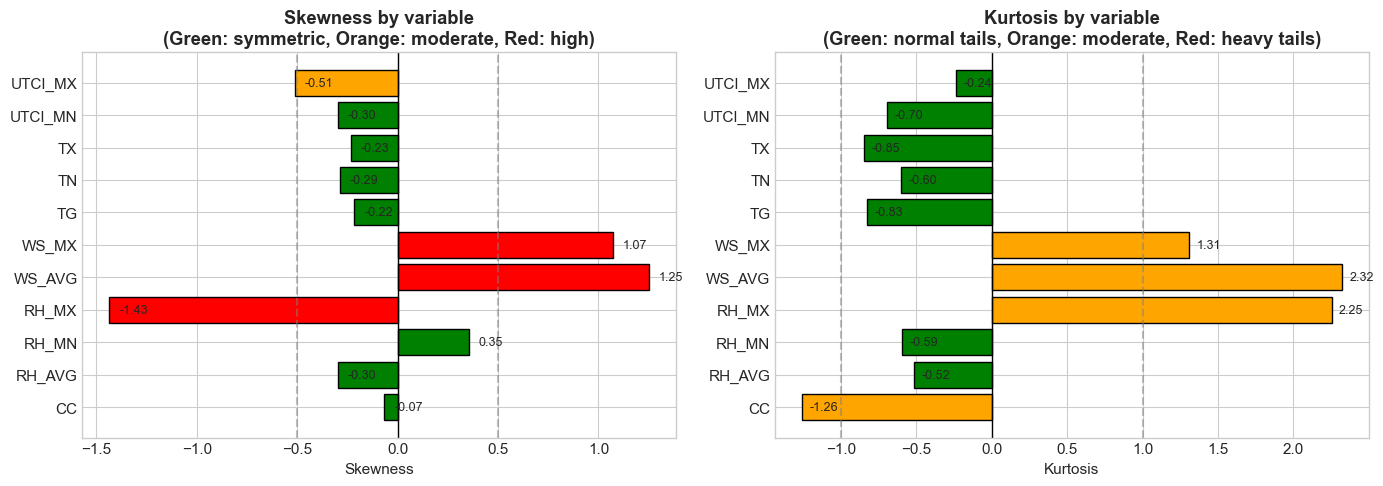

In [17]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

skew_vals = df[numeric_cols].skew()
colors_skew = ['green' if abs(v) < 0.5 else 'orange' if abs(v) < 1 else 'red' for v in skew_vals]
axes[0].barh(numeric_cols, skew_vals, color=colors_skew, edgecolor='black')
axes[0].axvline(0, color='black', linewidth=1)
axes[0].axvline(-0.5, color='gray', linestyle='--', alpha=0.5)
axes[0].axvline(0.5, color='gray', linestyle='--', alpha=0.5)
axes[0].set_xlabel('Skewness')
axes[0].set_title('Skewness by variable\n(Green: symmetric, Orange: moderate, Red: high)', fontweight='bold')
for i, v in enumerate(skew_vals):
    axes[0].text(v + 0.05, i, f'{v:.2f}', va='center', fontsize=9)

kurt_vals = df[numeric_cols].kurtosis()
colors_kurt = ['green' if abs(v) < 1 else 'orange' if abs(v) < 3 else 'red' for v in kurt_vals]
axes[1].barh(numeric_cols, kurt_vals, color=colors_kurt, edgecolor='black')
axes[1].axvline(0, color='black', linewidth=1)
axes[1].axvline(-1, color='gray', linestyle='--', alpha=0.5)
axes[1].axvline(1, color='gray', linestyle='--', alpha=0.5)
axes[1].set_xlabel('Kurtosis')
axes[1].set_title('Kurtosis by variable\n(Green: normal tails, Orange: moderate, Red: heavy tails)', fontweight='bold')
for i, v in enumerate(kurt_vals):
    axes[1].text(v + 0.05, i, f'{v:.2f}', va='center', fontsize=9)

plt.tight_layout()
plt.show()

In [18]:
missing = df.isnull().sum()
if missing.sum() == 0:
    print('No missing values!')
else:
    print(missing[missing > 0])

No missing values!


In [19]:
print(f'TN <= TG <= TX: {((df["TN"] <= df["TG"]) & (df["TG"] <= df["TX"])).all()}')
print(f'RH_MN <= RH_AVG <= RH_MX: {((df["RH_MN"] <= df["RH_AVG"]) & (df["RH_AVG"] <= df["RH_MX"])).all()}')
print(f'WS_AVG <= WS_MX: {(df["WS_AVG"] <= df["WS_MX"]).all()}')
print(f'UTCI_MN <= UTCI_MX: {(df["UTCI_MN"] <= df["UTCI_MX"]).all()}')

TN <= TG <= TX: True
RH_MN <= RH_AVG <= RH_MX: True
WS_AVG <= WS_MX: True
UTCI_MN <= UTCI_MX: True


---
## 5. Distribution Analysis

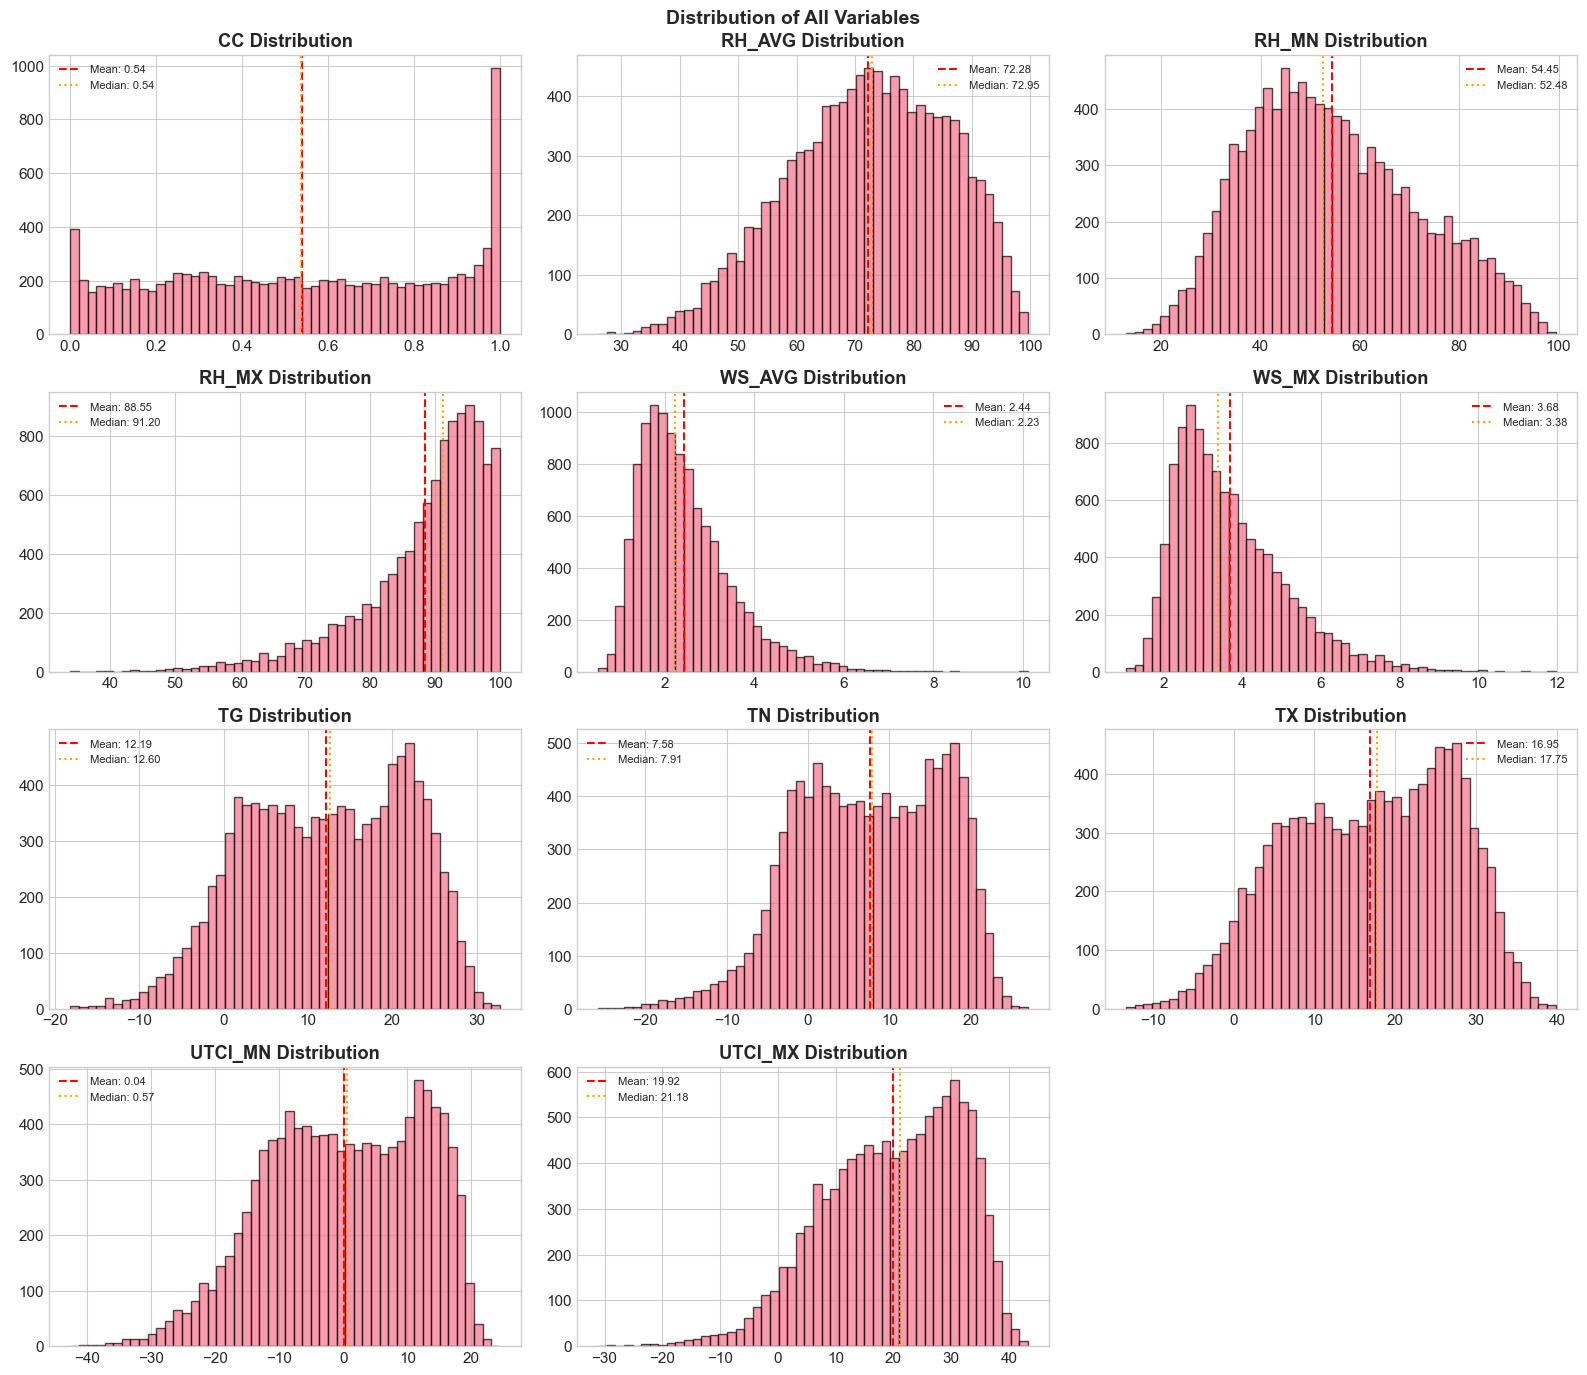

In [20]:
fig, axes = plt.subplots(4, 3, figsize=(16, 14))
axes = axes.flatten()

for i, col in enumerate(numeric_cols):
    ax = axes[i]
    ax.hist(df[col], bins=50, edgecolor='black', alpha=0.7)
    ax.axvline(df[col].mean(), color='red', linestyle='--', label=f'Mean: {df[col].mean():.2f}')
    ax.axvline(df[col].median(), color='orange', linestyle=':', label=f'Median: {df[col].median():.2f}')
    ax.set_title(f'{col} Distribution', fontweight='bold')
    ax.legend(fontsize=8)

axes[-1].set_visible(False)
plt.suptitle('Distribution of All Variables', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

---
## 6. Time Series Visualization

In [21]:
df_ts = df.set_index('date')

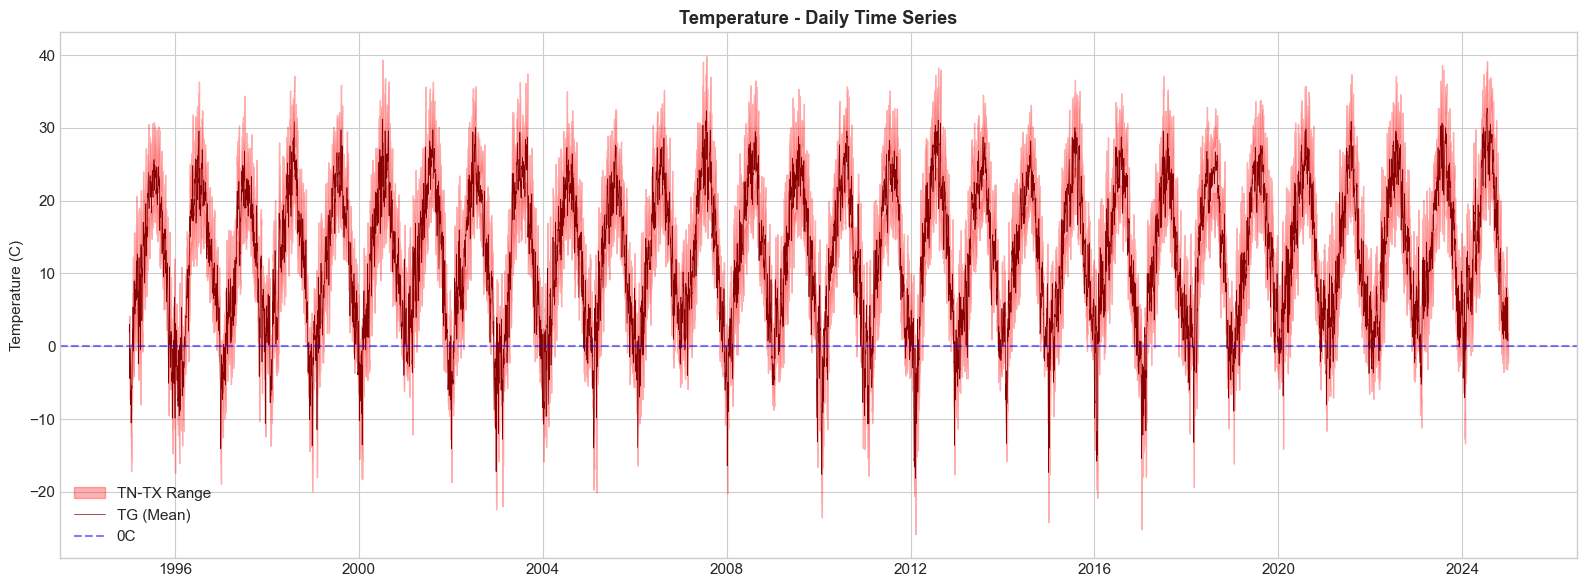

In [ ]:
fig, ax = plt.subplots(figsize=(16, 6))
ax.fill_between(df_ts.index, df_ts['TN'], df_ts['TX'], alpha=0.3, color='red', label='TN-TX Range')
ax.plot(df_ts.index, df_ts['TG'], linewidth=0.5, color='darkred', label='TG (Mean)')
ax.axhline(0, color='blue', linestyle='--', alpha=0.5, label='0C')
ax.set_title('Temperature - Daily Time Series', fontweight='bold')
ax.set_ylabel('Temperature (C)')
ax.legend()
plt.tight_layout()
plt.show()

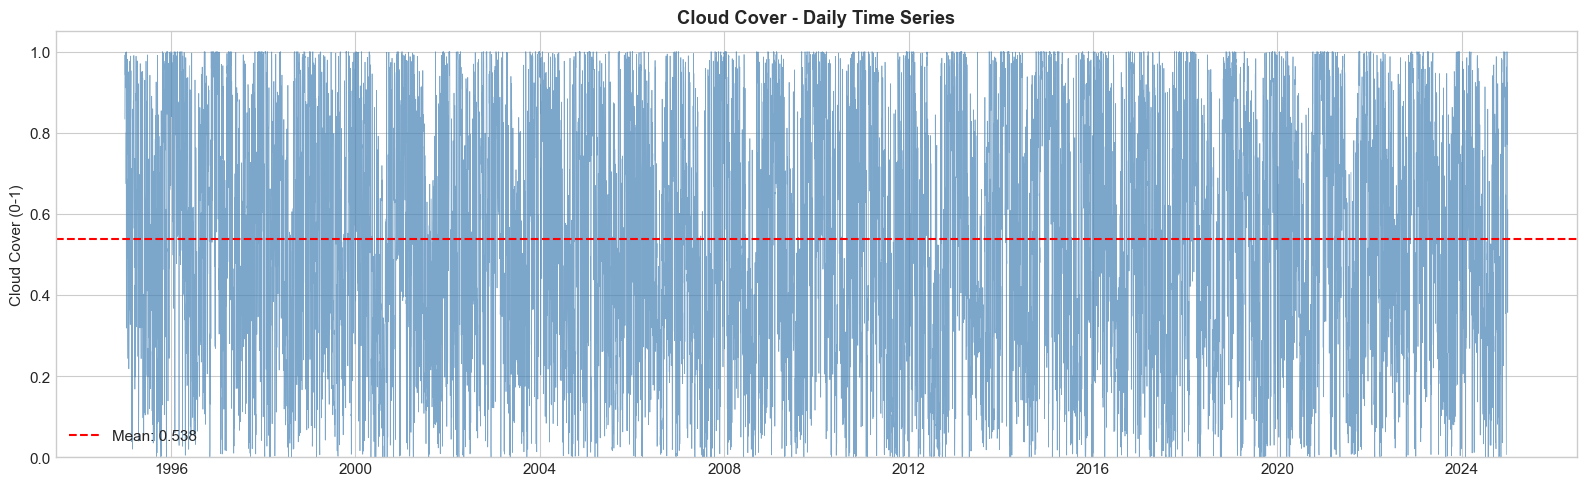

In [ ]:
fig, ax = plt.subplots(figsize=(16, 5))
ax.plot(df_ts.index, df_ts['CC'], linewidth=0.5, alpha=0.7, color='steelblue')
ax.axhline(df_ts['CC'].mean(), color='red', linestyle='--', label=f'Mean: {df_ts["CC"].mean():.3f}')
ax.set_title('Cloud Cover - Daily Time Series', fontweight='bold')
ax.set_ylabel('Cloud Cover (0-1)')
ax.set_ylim(0, 1.05)
ax.legend()
plt.tight_layout()
plt.show()

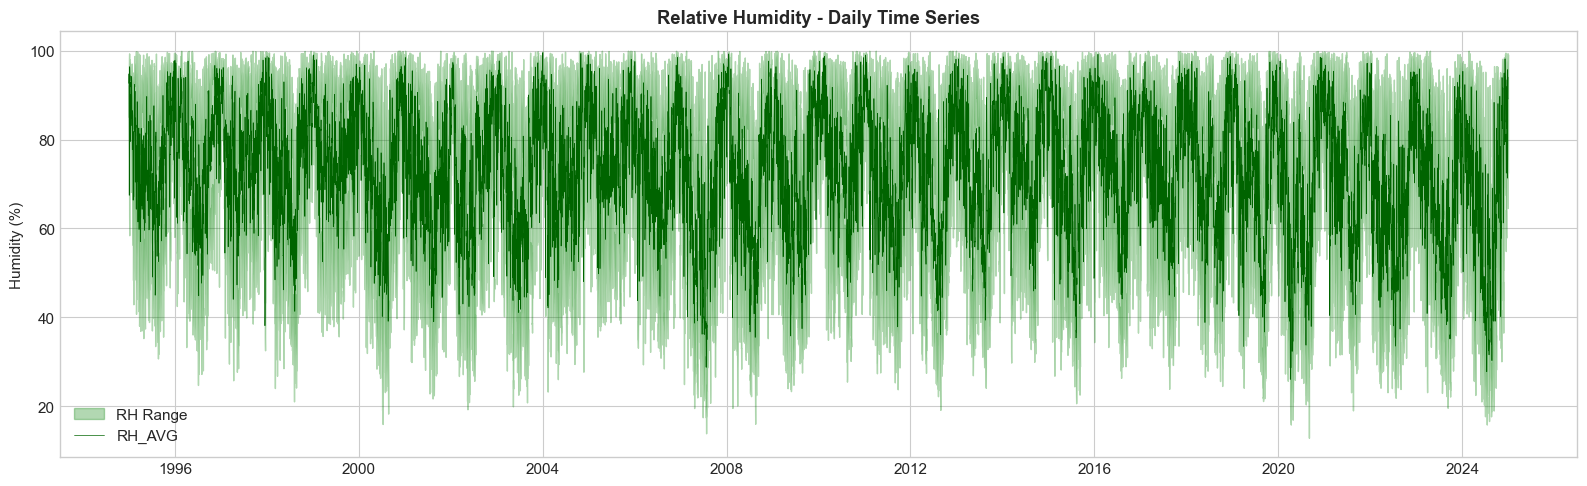

In [ ]:
fig, ax = plt.subplots(figsize=(16, 5))
ax.fill_between(df_ts.index, df_ts['RH_MN'], df_ts['RH_MX'], alpha=0.3, color='green', label='RH Range')
ax.plot(df_ts.index, df_ts['RH_AVG'], linewidth=0.5, color='darkgreen', label='RH_AVG')
ax.set_title('Relative Humidity - Daily Time Series', fontweight='bold')
ax.set_ylabel('Humidity (%)')
ax.legend()
plt.tight_layout()
plt.show()

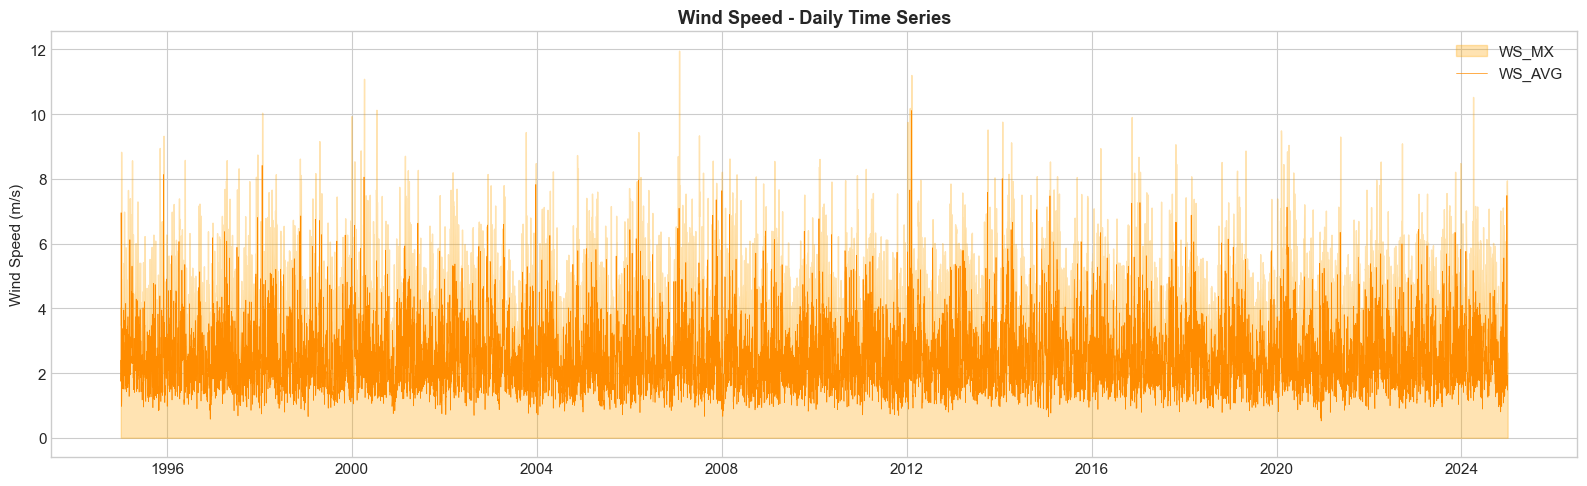

In [ ]:
fig, ax = plt.subplots(figsize=(16, 5))
ax.fill_between(df_ts.index, 0, df_ts['WS_MX'], alpha=0.3, color='orange', label='WS_MX')
ax.plot(df_ts.index, df_ts['WS_AVG'], linewidth=0.5, color='darkorange', label='WS_AVG')
ax.set_title('Wind Speed - Daily Time Series', fontweight='bold')
ax.set_ylabel('Wind Speed (m/s)')
ax.legend()
plt.tight_layout()
plt.show()

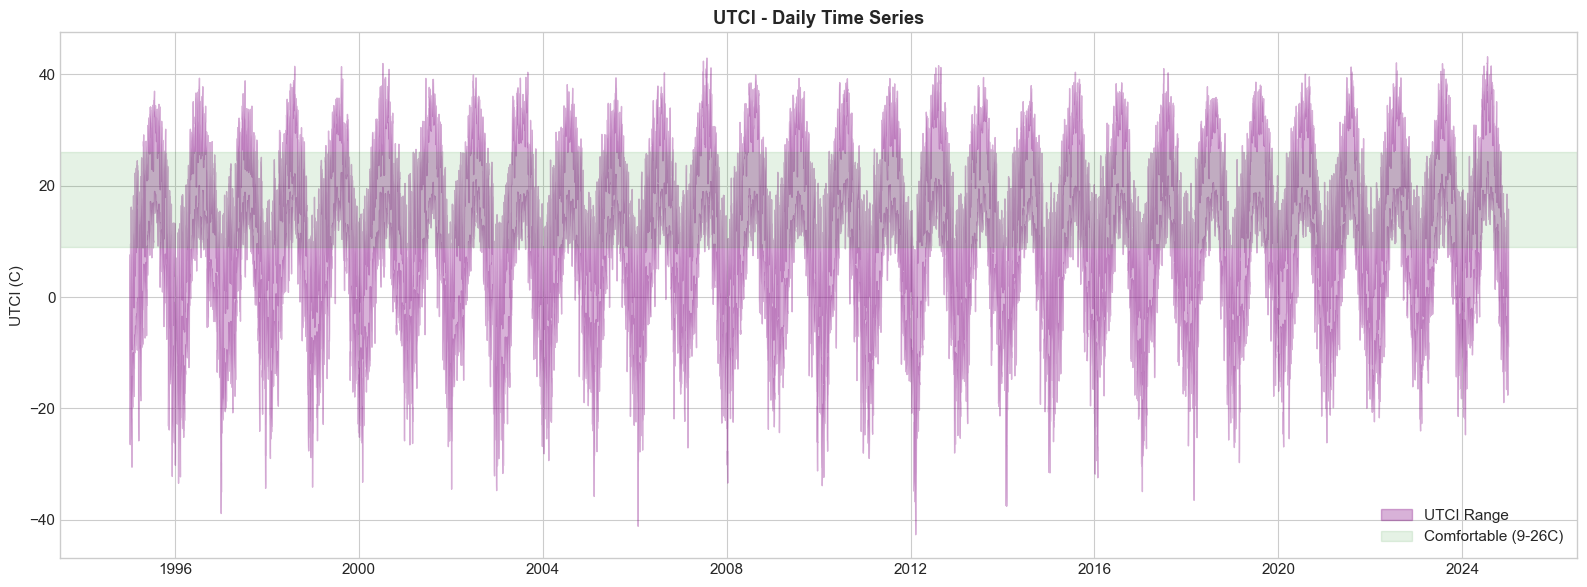

In [ ]:
fig, ax = plt.subplots(figsize=(16, 6))
ax.fill_between(df_ts.index, df_ts['UTCI_MN'], df_ts['UTCI_MX'], alpha=0.3, color='purple', label='UTCI Range')
ax.axhspan(9, 26, alpha=0.1, color='green', label='Comfortable (9-26C)')
ax.set_title('UTCI - Daily Time Series', fontweight='bold')
ax.set_ylabel('UTCI (C)')
ax.legend()
plt.tight_layout()
plt.show()

---
## 7. Seasonal Patterns

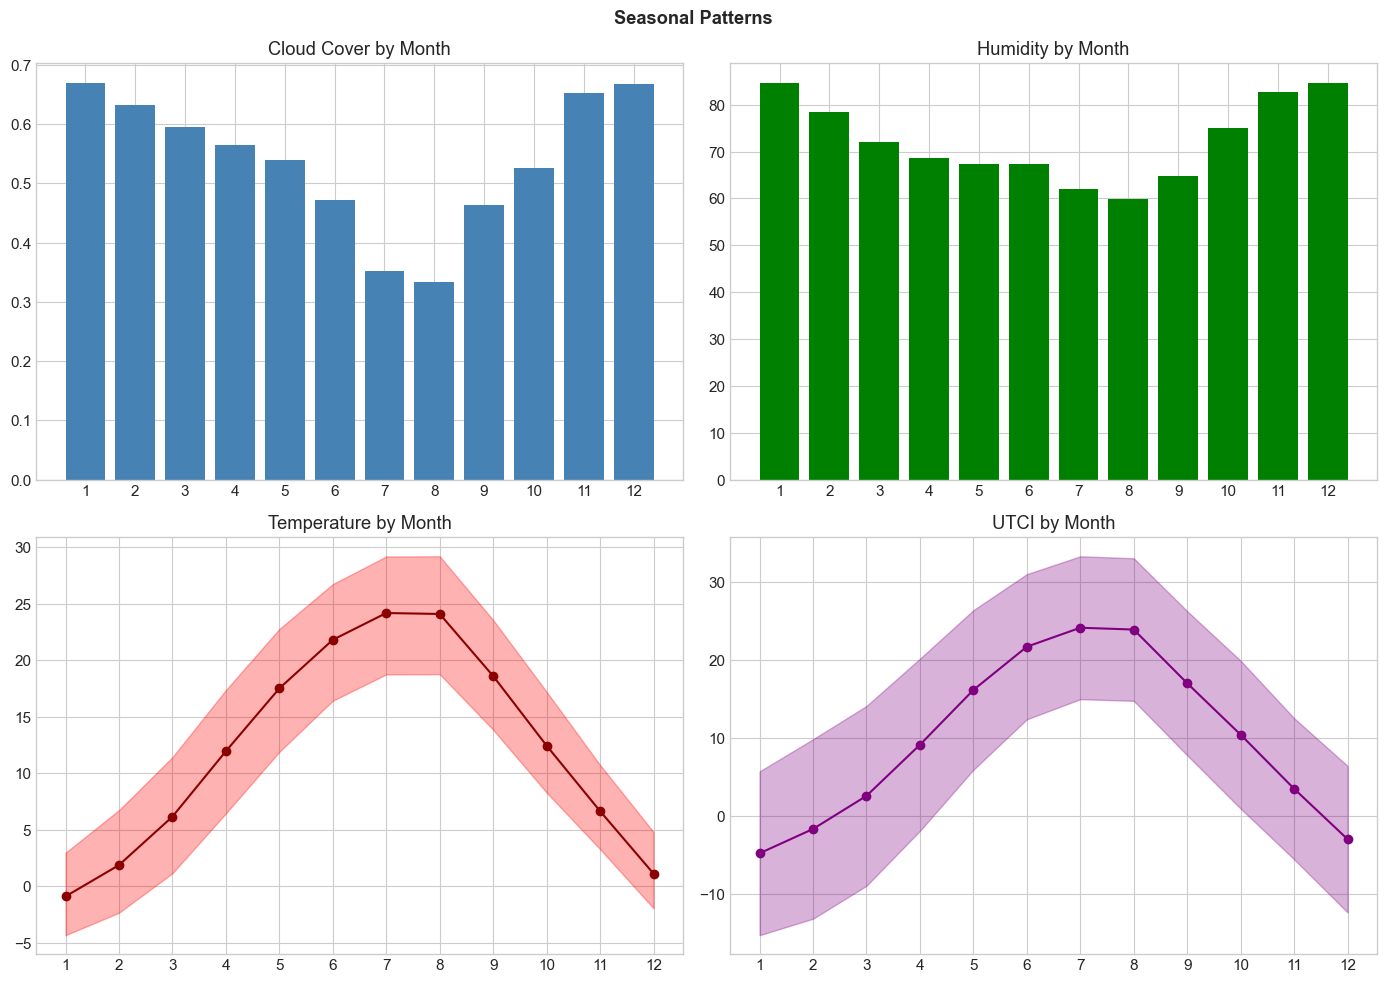

In [27]:
df_ts['month'] = df_ts.index.month
df_ts['year'] = df_ts.index.year

monthly_avg = df_ts.groupby('month')[numeric_cols].mean()

fig, axes = plt.subplots(2, 2, figsize=(14, 10))

axes[0,0].bar(monthly_avg.index, monthly_avg['CC'], color='steelblue')
axes[0,0].set_title('Cloud Cover by Month')
axes[0,0].set_xticks(range(1,13))

axes[0,1].bar(monthly_avg.index, monthly_avg['RH_AVG'], color='green')
axes[0,1].set_title('Humidity by Month')
axes[0,1].set_xticks(range(1,13))

axes[1,0].plot(monthly_avg.index, monthly_avg['TG'], 'o-', color='darkred')
axes[1,0].fill_between(monthly_avg.index, monthly_avg['TN'], monthly_avg['TX'], alpha=0.3, color='red')
axes[1,0].set_title('Temperature by Month')
axes[1,0].set_xticks(range(1,13))

axes[1,1].fill_between(monthly_avg.index, monthly_avg['UTCI_MN'], monthly_avg['UTCI_MX'], alpha=0.3, color='purple')
axes[1,1].plot(monthly_avg.index, (monthly_avg['UTCI_MN']+monthly_avg['UTCI_MX'])/2, 'o-', color='purple')
axes[1,1].set_title('UTCI by Month')
axes[1,1].set_xticks(range(1,13))

plt.suptitle('Seasonal Patterns', fontweight='bold')
plt.tight_layout()
plt.show()

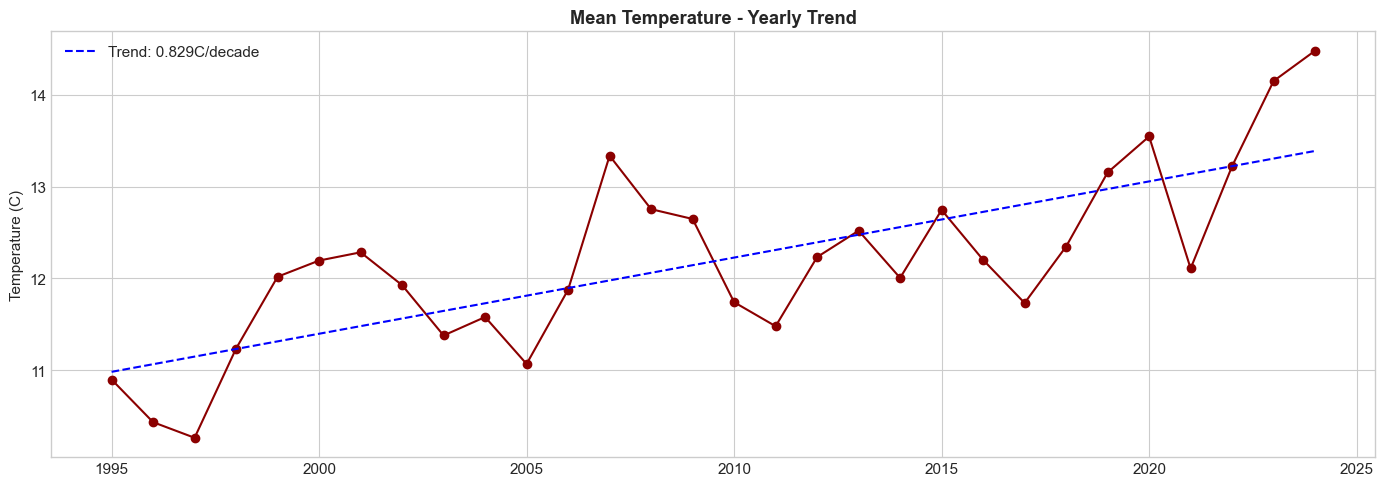

In [ ]:
yearly_avg = df_ts.groupby('year')[numeric_cols].mean()

fig, ax = plt.subplots(figsize=(14, 5))
ax.plot(yearly_avg.index, yearly_avg['TG'], 'o-', color='darkred')
z = np.polyfit(yearly_avg.index, yearly_avg['TG'], 1)
p = np.poly1d(z)
ax.plot(yearly_avg.index, p(yearly_avg.index), '--', color='blue', label=f'Trend: {z[0]*10:.3f}C/decade')
ax.set_title('Mean Temperature - Yearly Trend', fontweight='bold')
ax.set_ylabel('Temperature (C)')
ax.legend()
plt.tight_layout()
plt.show()

---
## 8. Correlation Analysis

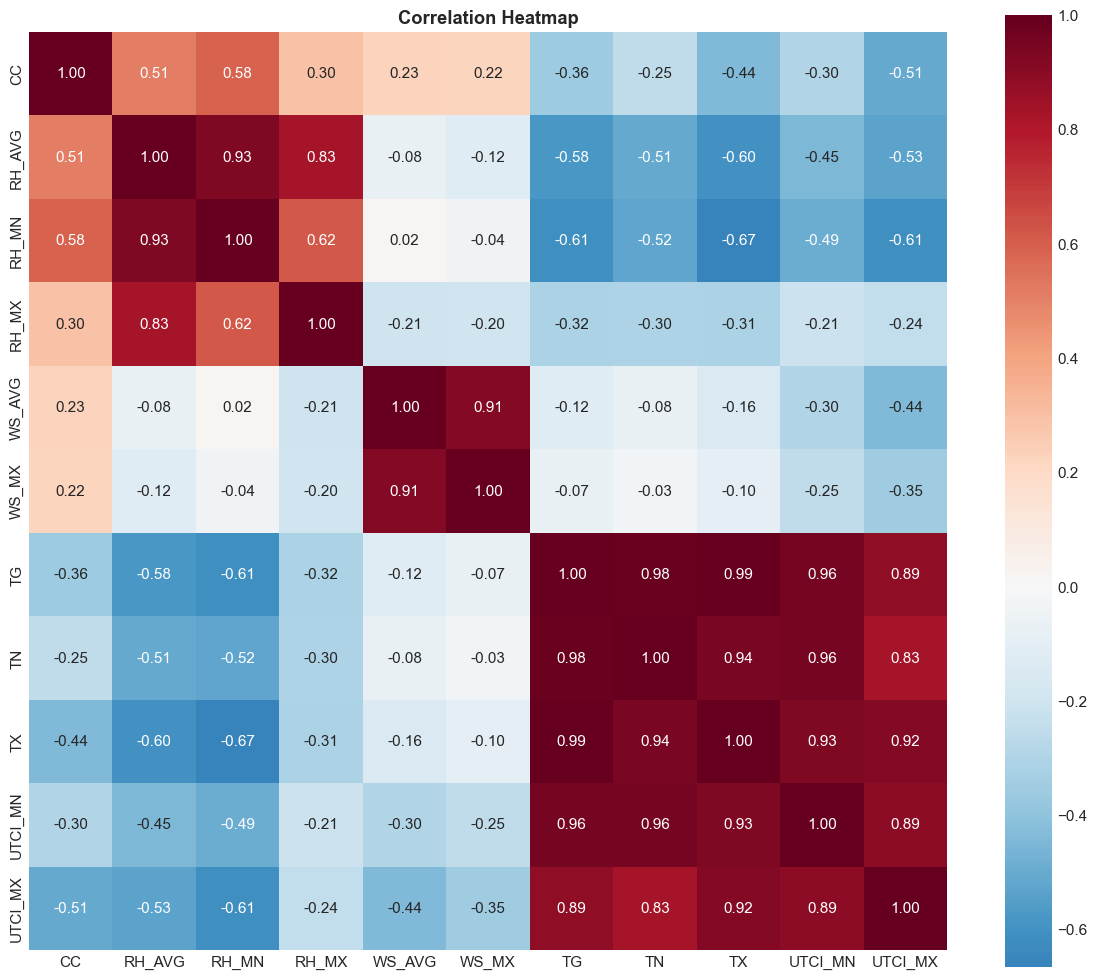

In [29]:
corr_matrix = df[numeric_cols].corr()

plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='RdBu_r', center=0, square=True)
plt.title('Correlation Heatmap', fontweight='bold')
plt.tight_layout()
plt.show()

In [30]:
print('Strong correlations (|r| > 0.7):')
for i in range(len(corr_matrix.columns)):
    for j in range(i+1, len(corr_matrix.columns)):
        r = corr_matrix.iloc[i, j]
        if abs(r) > 0.7:
            print(f'{corr_matrix.columns[i]} <-> {corr_matrix.columns[j]}: r = {r:.3f}')

Strong correlations (|r| > 0.7):
RH_AVG <-> RH_MN: r = 0.929
RH_AVG <-> RH_MX: r = 0.826
WS_AVG <-> WS_MX: r = 0.909
TG <-> TN: r = 0.981
TG <-> TX: r = 0.987
TG <-> UTCI_MN: r = 0.957
TG <-> UTCI_MX: r = 0.889
TN <-> TX: r = 0.943
TN <-> UTCI_MN: r = 0.956
TN <-> UTCI_MX: r = 0.830
TX <-> UTCI_MN: r = 0.935
TX <-> UTCI_MX: r = 0.918
UTCI_MN <-> UTCI_MX: r = 0.890


---
## 9. Anomaly Detection

In [31]:
print(f'Hottest day: {df.loc[df["TX"].idxmax(), "date"]} - TX: {df["TX"].max():.1f}C')
print(f'Coldest day: {df.loc[df["TN"].idxmin(), "date"]} - TN: {df["TN"].min():.1f}C')
print(f'Windiest day: {df.loc[df["WS_MX"].idxmax(), "date"]} - WS_MX: {df["WS_MX"].max():.1f} m/s')
print(f'Max heat stress: {df.loc[df["UTCI_MX"].idxmax(), "date"]} - UTCI_MX: {df["UTCI_MX"].max():.1f}C')
print(f'Max cold stress: {df.loc[df["UTCI_MN"].idxmin(), "date"]} - UTCI_MN: {df["UTCI_MN"].min():.1f}C')

Hottest day: 2007-07-23 00:00:00 - TX: 39.8C
Coldest day: 2012-02-09 00:00:00 - TN: -25.8C
Windiest day: 2007-01-29 00:00:00 - WS_MX: 12.0 m/s
Max heat stress: 2024-07-17 00:00:00 - UTCI_MX: 43.2C
Max cold stress: 2012-02-07 00:00:00 - UTCI_MN: -42.6C


In [35]:
MORTALITY_RISK_THRESHOLD = 38
extreme_days = df[(df['UTCI_MX'] > MORTALITY_RISK_THRESHOLD) | (df['TX'] > MORTALITY_RISK_THRESHOLD)].copy()
extreme_days = extreme_days.sort_values('UTCI_MX', ascending=False)

print('Top 10 most extreme days - Highest Mortality Risk')
print('=' * 70)
print(extreme_days[['date', 'TX', 'TN', 'UTCI_MX', 'RH_MX', 'RH_AVG']].head(10).to_string(index=False))

Top 10 most extreme days - Highest Mortality Risk
      date        TX        TN   UTCI_MX     RH_MX    RH_AVG
2024-07-17 39.196018 24.749264 43.241322 70.443372 41.212267
2007-07-24 39.034386 22.873446 43.004758 50.492332 31.219303
2024-07-18 38.933736 26.783222 42.794982 61.200474 39.881991
2007-07-22 38.223737 21.665886 42.651874 67.867437 34.776116
2007-06-26 39.095721 22.086913 42.446035 75.175619 44.108565
2007-07-23 39.841697 23.766558 42.145589 57.441663 28.782756
2022-07-24 37.124002 21.076620 42.139098 80.652247 44.027329
2024-07-15 38.614292 23.099111 42.098162 53.686051 27.765168
2000-07-05 39.380933 21.596512 42.018413 81.798068 44.095207
2023-07-25 38.655599 22.472932 41.996004 69.468594 45.160963


---
## 10. Summary

In [33]:
print(f'Date range: {df["date"].min()} to {df["date"].max()}')
print(f'Total records: {len(df):,}')
print(f'Mean Temperature: {df["TG"].mean():.2f}C (std: {df["TG"].std():.2f})')
print(f'Temperature range: {df["TN"].min():.1f}C to {df["TX"].max():.1f}C')
print(f'Mean Cloud Cover: {df["CC"].mean():.2f}')
print(f'Mean Humidity: {df["RH_AVG"].mean():.1f}%')
print(f'Mean Wind Speed: {df["WS_AVG"].mean():.2f} m/s')

Date range: 1995-01-01 00:00:00 to 2024-12-31 00:00:00
Total records: 10,958
Mean Temperature: 12.19C (std: 9.54)
Temperature range: -25.8C to 39.8C
Mean Cloud Cover: 0.54
Mean Humidity: 72.3%
Mean Wind Speed: 2.44 m/s


In [36]:
df.to_csv('../data/processed_data/processed_UAT_403.csv', index=False)